In [1]:
#import needed libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from imblearn.over_sampling import SMOTE
from time import time
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm_notebook as tqdm
sns.set()
%matplotlib inline
import warnings
warning = [DeprecationWarning, FutureWarning, UserWarning]
for w in warning:
    warnings.filterwarnings("ignore", category=w)

Using TensorFlow backend.


In [2]:
#Windows beep for ending tasks
import winsound
def done():
    frequency = 2000  
    duration = 400  
    return winsound.Beep(frequency, duration)

In [3]:
%%time
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

Wall time: 5.82 s


In [4]:
#Let's look what is the size of the datasets 
print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (200000, 202)
Test Shape: (200000, 201)


In [5]:
pd.set_option('display.max_columns', None) #display all columns
pd.set_option('display.max_rows', None) #display all rows
train.head(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

## Data Exploration and Visualization

In [6]:
# Total number of records
n_records = len(train)

# Number of records where the client made the transaction
made = train.target.sum()

# Number of records where the client didn't make the transaction
didnt_make = n_records - made

# Percentage of transaction made
percentage = made / n_records 

# Print the results
print("Total number of records: {}".format(n_records))
print("Clients that made the transaction: {}".format(made))
print("Clients that didn't make the transaction: {}".format(didnt_make))
print("Percentage of clients that made the transaction: {}%".format(percentage*100))

Total number of records: 200000
Clients that made the transaction: 20098
Clients that didn't make the transaction: 179902
Percentage of clients that made the transaction: 10.049%


In [7]:
#Basic Statistics of the train data:
basic_stats = train.describe()
basic_stats

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2000

In [8]:
print("Mean range: {:.2f} -> {:.2f}".format(basic_stats.T['mean'].min(), basic_stats.T['mean'].max()))
print("Median range: {:.2f} -> {:.2f}".format(basic_stats.T['50%'].min(), basic_stats.T['50%'].max()))
print("Std range: {:.2f} -> {:.2f}".format(basic_stats.T['std'].min(), basic_stats.T['std'].max()))
print("Min range: {:.2f} -> {:.2f}".format(basic_stats.T['min'].min(), basic_stats.T['min'].max()))
print("Max range: {:.2f} -> {:.2f}".format(basic_stats.T['max'].min(), basic_stats.T['max'].max()))


Mean range: -16.55 -> 24.52
Median range: -16.48 -> 24.45
Std range: 0.01 -> 21.40
Min range: -90.25 -> 13.73
Max range: 1.00 -> 74.03


In [9]:
null_values = train.drop(['target', 'ID_code'], axis=1).isnull().values.any()
na_values = train.drop(['target', 'ID_code'], axis=1).isna().values.any()
print('There is {} Null Values in the training set.'.format(null_values.sum()))
print('There is {} NaN Values in the training set.'.format(na_values.sum()))

There is 0 Null Values in the training set.
There is 0 NaN Values in the training set.


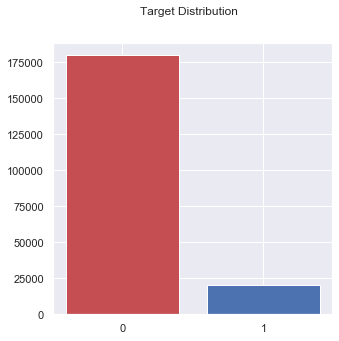

In [10]:
#Plot of distribution of 0 and 1 in the target
plt.figure(figsize=(5,5))
plt.suptitle('Target Distribution')
plt.bar(['0', '1'],train.target.value_counts(), color = ['r', 'b'])
plt.savefig('assets/target.png')
plt.show()

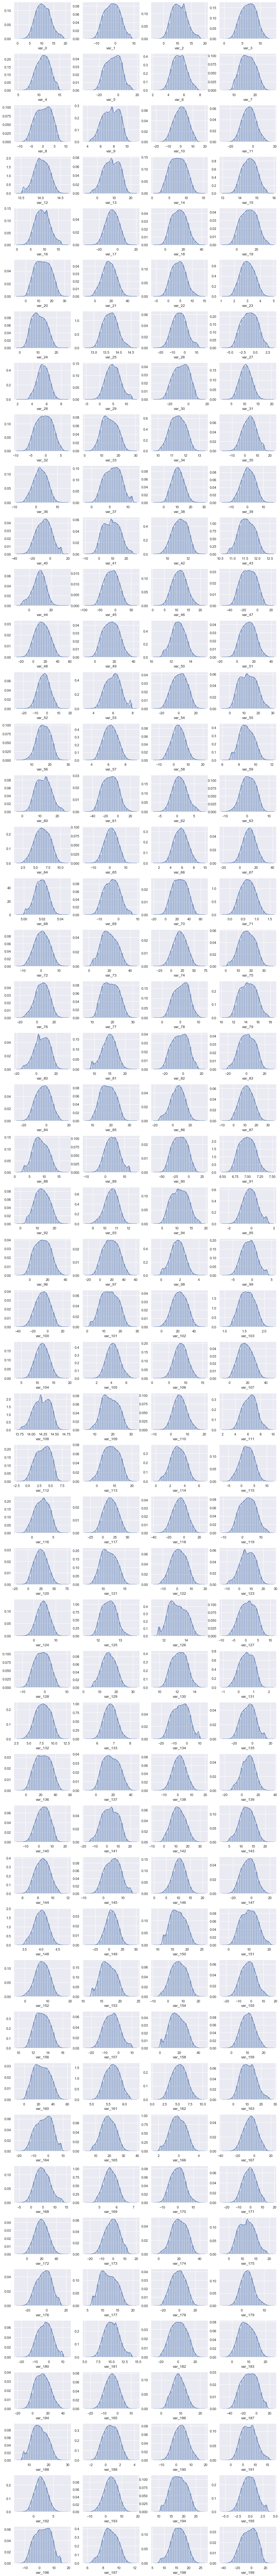

In [11]:
#Ploting histograms of the features.

plt.figure(figsize=(15, 150))
for i, col in enumerate(train.columns[2:202]):
    plt.subplot(50, 4, i + 1)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
    sns.distplot(train[col],20)
plt.savefig('assets/features.png')

## Preprocessing the data

In [12]:
def data_preprocess(raw_data, size, scaler=None):
    '''
    Preprocessing data pipeline
    raw_data = Data for preprocessing (can also be the training or the test set)
    size = Float. Stratified sample size. Ex: 0.5 for 50%; 1. for 100%.
    scaler = String. StandardScaler or MinMaxScaler. Default = None
    '''
    #get a fraction of the data
    if size == 1.:
        strat_data = raw_data
    else:
        strat_data = raw_data.sample(frac = size, random_state = 0)
    
    #get target
    if 'target' in strat_data.columns:
        y = strat_data['target']
    else:
        y = None
    
    #get features
    columns = ['ID_code', 'target']
    for c in strat_data.columns:
        if c in columns:
            strat_data = strat_data.drop(c, axis = 1)
             
    #Feature Scaling
    if scaler == 'StandardScaler':
        scaler = StandardScaler()     
        X = pd.DataFrame(scaler.fit_transform(strat_data), columns= strat_data.columns)
    elif scaler == 'MinMaxScaler':
        scaler = MinMaxScaler()  
        X = pd.DataFrame(scaler.fit_transform(strat_data), columns= strat_data.columns)
    else:
        X = strat_data
    
   
    return X, y

In [13]:
X, y = data_preprocess(train, 1.,)

In [14]:
#Identifing collinear (highly correlated) features: 
df_corr = round(X.corr(),4)
max_pos_corr = []
min_neg_corr = []
for c in df_corr.columns:
    max_pos_corr.append(df_corr[df_corr[c]< 1.0][c].max())
    min_neg_corr.append(df_corr[df_corr[c]< 1.0][c].min())
print('Strongest positive correlation found: {}'.format(max(max_pos_corr)))
print('Strongest negative correlation found: {}'.format(min(min_neg_corr)))

Strongest positive correlation found: 0.0097
Strongest negative correlation found: -0.0098


# Baseline Model - Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [16]:
#Return matrices for XGBoost
def get_xgb_matrix(X_train, X_test, y_train, y_test):
    D_train = xgb.DMatrix(X_train, label=y_train)
    D_test = xgb.DMatrix(X_test, label=y_test)
    return D_train, D_test

In [17]:
#Creating train, test, split and transforming into XGBoost Matrices
def get_splits(X,y, DMatrix = True):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                      y,
                                      test_size = 0.20,
                                      random_state=0)
    if DMatrix == True:
        D_train, D_test = get_xgb_matrix(X_train, X_test, y_train, y_test)
        return D_train, D_test, y_test
    else:
        return X_train, X_test, y_train, y_test

In [18]:
#Calculate the metrics of the model
def metrics(y_test, predictions, probabilities):
    cm = confusion_matrix(y_test, predictions)
    auc = round(roc_auc_score(y_test, probabilities), 4)
    fpr = round(100 * (cm[0][1]/(cm[0][0]+cm[0][1])))
    tpr = recall_score(y_test, predictions)
    ppv = precision_score(y_test, predictions)
    return cm, auc, fpr, tpr, ppv

## Baseline Model Training

In [21]:
smt = SMOTE()

In [26]:
results = {}

for n in tqdm(np.arange(1, 11)):
    start_time = time()
    
    X, y = data_preprocess(train, .1 * n, scaler= 'StandardScaler')

    X_train, X_test, y_train, y_test_LR = get_splits(X, y, DMatrix= False)

    #X_train, y_train = smt.fit_sample(X_train, y_train)
    
    baseline_model = LogisticRegressionCV(cv = 10, penalty='l2', n_jobs=-1)
    baseline_model.fit(X_train, y_train)

    preds_LR = baseline_model.predict(X_test)
    proba_LR = baseline_model.predict_proba(X_test)[:,1]
    
    end_time = time()

    cm, auc, fpr, tpr, ppv = metrics(y_test_LR, preds_LR, proba_LR)   
    results[n] = {"Data_Size": n * 0.1,
                  "Time": end_time - start_time,
                  "TN": cm[0][0],
                  "FP": cm[0][1],
                  "FN": cm[1][0],
                  "TP": cm[1][1],
                  "AUC": auc,
                  "FPR": fpr,
                  "TPR": tpr,
                  "PPV": ppv
                 }
print("Done.")
sys.stdout.flush()
done()


Done.


In [27]:
cols = ["Data_Size", "Time", "TN", "FP", "FN","TP","FPR","TPR","PPV","AUC"]
df_results = pd.DataFrame(results).T[cols]
df_results

,Data_Size,Time,TN,FP,FN,TP,FPR,TPR,PPV,AUC
1,0.1,3.613806,3539.0,61.0,311.0,89.0,2.0,0.222500,0.593333,0.8336
2,0.2,5.267683,7138.0,95.0,583.0,184.0,1.0,0.239896,0.659498,0.8478
3,0.3,6.545975,10595.0,134.0,973.0,298.0,1.0,0.234461,0.689815,0.8553
4,0.4,7.740729,14253.0,191.0,1153.0,403.0,1.0,0.258997,0.678451,0.8597
5,0.5,9.237572,17716.0,218.0,1556.0,510.0,1.0,0.246854,0.700549,0.8621
6,0.6,10.660888,21254.0,280.0,1876.0,590.0,1.0,0.239254,0.678161,0.8593
7,0.7,12.321748,24754.0,360.0,2096.0,790.0,1.0,0.273735,0.686957,0.8632
8,0.8,13.645044,28477.0,352.0,2351.0,820.0,1.0,0.258594,0.699659,0.8580
9,0.9,14.809844,31884.0,444.0,2715.0,957.0,1.0,0.260621,0.683084,0.8598
10,1.0,16.136600,35488.0,498.0,2939.0,1075.0,1.0,0.267813,0.683408,0.8539


In [28]:
print("AUC Result: %", round(df_results.AUC.mean(),4))
print("FPR Result: %", round(df_results.FPR.mean(),4))
print("Recall Result: %", round(df_results.TPR.mean(),4))
print("Precision Result: %", round(df_results.PPV.mean(),4))

AUC Result: % 0.8553
FPR Result: % 1.1
Recall Result: % 0.2503
Precision Result: % 0.6753


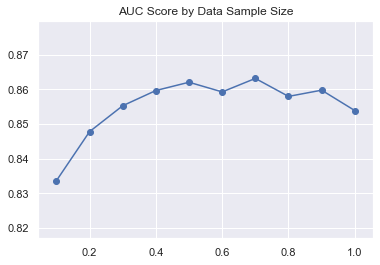

In [29]:
plt.scatter(df_results['Data_Size'], df_results['AUC'])
plt.plot(df_results['Data_Size'], df_results['AUC'])
plt.title('AUC Score by Data Sample Size')
plt.savefig('assets/AUC Score by Size.png')
plt.show()

# XGBoost Model

In [54]:
#Training XGBoost model function
def model_training(dtrain, params, rounds):
    model = xgb.train(dtrain= dtrain, params= params, num_boost_round= rounds)
    return model

In [55]:
#make predictions based on probabilities and a threshold
def get_preds(probabilities, threshold):
    return np.array([1 if x > threshold else 0 for x in probabilities])

In [93]:
results = {}
n= 1
X, y = data_preprocess(train, .5, scaler= 'StandardScaler')

X_train, X_test, y_train, y_test = get_splits(X, y, DMatrix= False)

model = xgb.XGBClassifier(n_jobs=-1)
model.fit(X_train, y_train)

preds = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

cm, auc, fpr, tpr, ppv = metrics(y_test, preds, proba)   
results[n] = {"TN": cm[0][0],
                  "FP": cm[0][1],
                  "FN": cm[1][0],
                  "TP": cm[1][1],
                  "AUC": auc,
                  "FPR": fpr,
                  "TPR": tpr,
                  "PPV": ppv
                 }
print("Done.")
sys.stdout.flush()
done()

Done.


In [94]:
cols = ["TN", "FP", "FN","TP","FPR","TPR","PPV","AUC"]
df_results = pd.DataFrame(results).T[cols]
df_results

,TN,FP,FN,TP,FPR,TPR,PPV,AUC
1,17931.0,3.0,2028.0,38.0,0.0,0.018393,0.926829,0.8306


In [95]:
print("AUC Result: %", round(df_results.AUC.mean(),4))
print("FPR Result: %", round(df_results.FPR.mean(),4))
print("Recall Result: %", round(df_results.TPR.mean(),4))
print("Precision Result: %", round(df_results.PPV.mean(),4))

AUC Result: % 0.8306
FPR Result: % 0.0
Recall Result: % 0.0184
Precision Result: % 0.9268


## Hyperparameters Optimization

In [56]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

X, y = data_preprocess(train, .5, 'StandardScaler')

D_train, D_test, y_test = get_splits(X,y, DMatrix=True)

def objective(space):
    # Instantiate the classifier
    params = {'colsample_bytree': space['colsample_bytree'], 
              'gamma': space['gamma'],
              'learning_rate': 0.1,            
              'max_depth': 3, 
              'min_child_weight': space['min_child_weight'], 
              'reg_alpha': space['reg_alpha'], 
              'scale_pos_weight': space['scale_pos_weight'], 
              'subsample': space['subsample'],
              'objective': "binary:logistic",
              'tree_method': 'gpu_hist',
              'silent': 1
         }
    
    model = model_training(D_train, params, 100)

    # Predict probabilities on training set
    probas = model.predict(D_test)
    
    # Calculate our Metric - AUC on testing set
    auc = roc_auc_score(y_test, probas)

    # return loss function.
    return {'loss': -auc, 'status': STATUS_OK }

In [57]:
space ={'min_child_weight': hp.quniform ('min_child_weight', 1, 5, 1),
        'subsample': hp.quniform ('subsample', 0.5, 1., 0.05),
        'gamma' : hp.quniform ('gamma', 5,10,1),
        'reg_alpha' : hp.quniform ('reg_alpha', 0.1,1.0,0.05),
        'colsample_bytree' : hp.quniform ('colsample_bytree', 0.2,0.9,0.1),
        'scale_pos_weight' : hp.uniform('scale_pos_weight', 8,10),
    }

In [58]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials)
print(best)
done()

100%|████████████████████████████████████████████████| 500/500 [07:20<00:00,  1.14it/s, best loss: -0.8430598922951975]
{'colsample_bytree': 0.2, 'gamma': 9.0, 'min_child_weight': 4.0, 'reg_alpha': 0.35000000000000003, 'scale_pos_weight': 8.920569929381536, 'subsample': 0.55}


In [59]:
#Getting the best hyperparameters 
def get_best_hyperparameters(best):
    params = best.copy()
    params['learning_rate'] = 0.1
    params['max_depth'] = 2
    params['objective'] = "binary:logistic"
    params['tree_method'] = 'gpu_hist'
    params['silent'] = 1
    return params

## Training and Validation

In [60]:
#Setting up RepeatedStratifiedKFold
splits = 4
repeats = 2
iterations = splits * repeats
rskf = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=0)

In [78]:
%%time

results_xgb = {}
count = 0

X, y = data_preprocess(train, .5, 'StandardScaler')

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      
    D_train, D_test = get_xgb_matrix(X_train, X_test, y_train, y_test)
    
    xgbmodel = model_training(D_train, get_best_hyperparameters(best), 2000)
    
    probas = xgbmodel.predict(D_test)

    preds = get_preds(probas, 0.5)
   
    cm, auc, fpr, tpr, ppv = metrics(y_test, preds, probas)   
    results_xgb[count] = {"TN": cm[0][0],
                      "FP": cm[0][1],
                      "FN": cm[1][0],
                      "TP": cm[1][1],
                      "AUC": auc,
                      "FPR": fpr,
                      "TPR": tpr,
                      "PPV": ppv
                     }
    count += 1
    print("\rTraining. {}/{} AUC= {}".format(count,iterations, auc), end=" ")
    sys.stdout.flush()
done()

Training. 8/8 AUC= 0.8916        Wall time: 1min 18s


In [79]:
cols = ["TN", "FP", "FN","TP","FPR","TPR","PPV","AUC"]
df_results_xgb = pd.DataFrame(results_xgb).T[cols]
df_results_xgb

,TN,FP,FN,TP,FPR,TPR,PPV,AUC
0,19428.0,3053.0,649.0,1871.0,14.0,0.742460,0.379976,0.8888
1,19247.0,3234.0,611.0,1908.0,14.0,0.757443,0.371062,0.8919
2,19383.0,3098.0,647.0,1872.0,14.0,0.743152,0.376660,0.8885
3,19358.0,3122.0,650.0,1869.0,14.0,0.741961,0.374474,0.8864
4,19299.0,3182.0,622.0,1898.0,14.0,0.753175,0.373622,0.8866
5,19343.0,3138.0,626.0,1893.0,14.0,0.751489,0.376267,0.8896
6,19392.0,3089.0,669.0,1850.0,14.0,0.734418,0.374570,0.8896
7,19243.0,3237.0,626.0,1893.0,14.0,0.751489,0.369006,0.8910


In [80]:
df_results_xgb.describe()

,TN,FP,FN,TP,FPR,TPR,PPV,AUC
count,8.000000,8.000000,8.000000,8.000000,8.0,8.000000,8.000000,8.000000
mean,19336.625000,3144.125000,637.500000,1881.750000,14.0,0.746948,0.374455,0.889050
std,67.905265,67.754678,19.190772,19.226098,0.0,0.007621,0.003392,0.001924
min,19243.000000,3053.000000,611.000000,1850.000000,14.0,0.734418,0.369006,0.886400
25%,19286.000000,3095.750000,625.000000,1870.500000,14.0,0.742336,0.372982,0.888025
50%,19350.500000,3130.000000,636.500000,1882.500000,14.0,0.747320,0.374522,0.889200
75%,19385.250000,3195.000000,649.250000,1894.250000,14.0,0.751910,0.376365,0.889950
max,19428.000000,3237.000000,669.000000,1908.000000,14.0,0.757443,0.379976,0.891900


numpy.ndarray

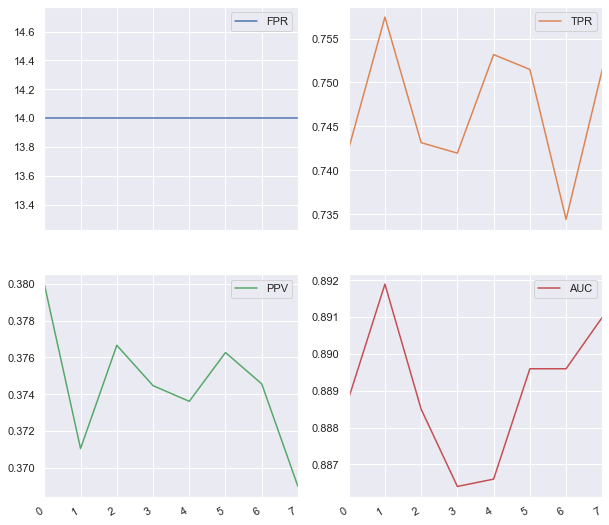

In [81]:
axes = df_results_xgb[["FPR","TPR","PPV","AUC"]].plot(subplots=True, layout=(2,2), figsize = (10,10))
type(axes)

In [82]:
print("Average AUC Result: %", round(df_results_xgb.AUC.mean(),4))
print("Average FPR Result: %", round(df_results_xgb.FPR.mean(),4))
print("Average TPR Result: %", round(df_results_xgb.TPR.mean(),4))
print("Average PPV Result: %", round(df_results_xgb.PPV.mean(),4))

Average AUC Result: % 0.889
Average FPR Result: % 14.0
Average TPR Result: % 0.7469
Average PPV Result: % 0.3745


### Save the model to disk

In [66]:
filename = 'finalized_model.sav'
pickle.dump(xgbmodel, open(filename, 'wb'))

## Feature Importances

In [67]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
ceate_feature_map(X)

In [68]:
def itemgetter(*items):
    if len(items) == 1:
        item = items[0]
        def g(obj):
            return obj[item]
    else:
        def g(obj):
            return tuple(obj[item] for item in items)
    return g

In [69]:
importance = xgbmodel.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore_ratio'] = df['fscore'] / df['fscore'].sum()
feat_imp = df.sort_values(by=['fscore'],ascending=False )
feat_imp.head(10)

,feature,fscore,fscore_ratio
199,var_166,54,0.009000
198,var_6,54,0.009000
197,var_99,54,0.009000
196,var_78,52,0.008667
195,var_21,51,0.008500
192,var_12,50,0.008333
194,var_34,50,0.008333
193,var_165,50,0.008333
191,var_174,49,0.008167
190,var_173,48,0.008000


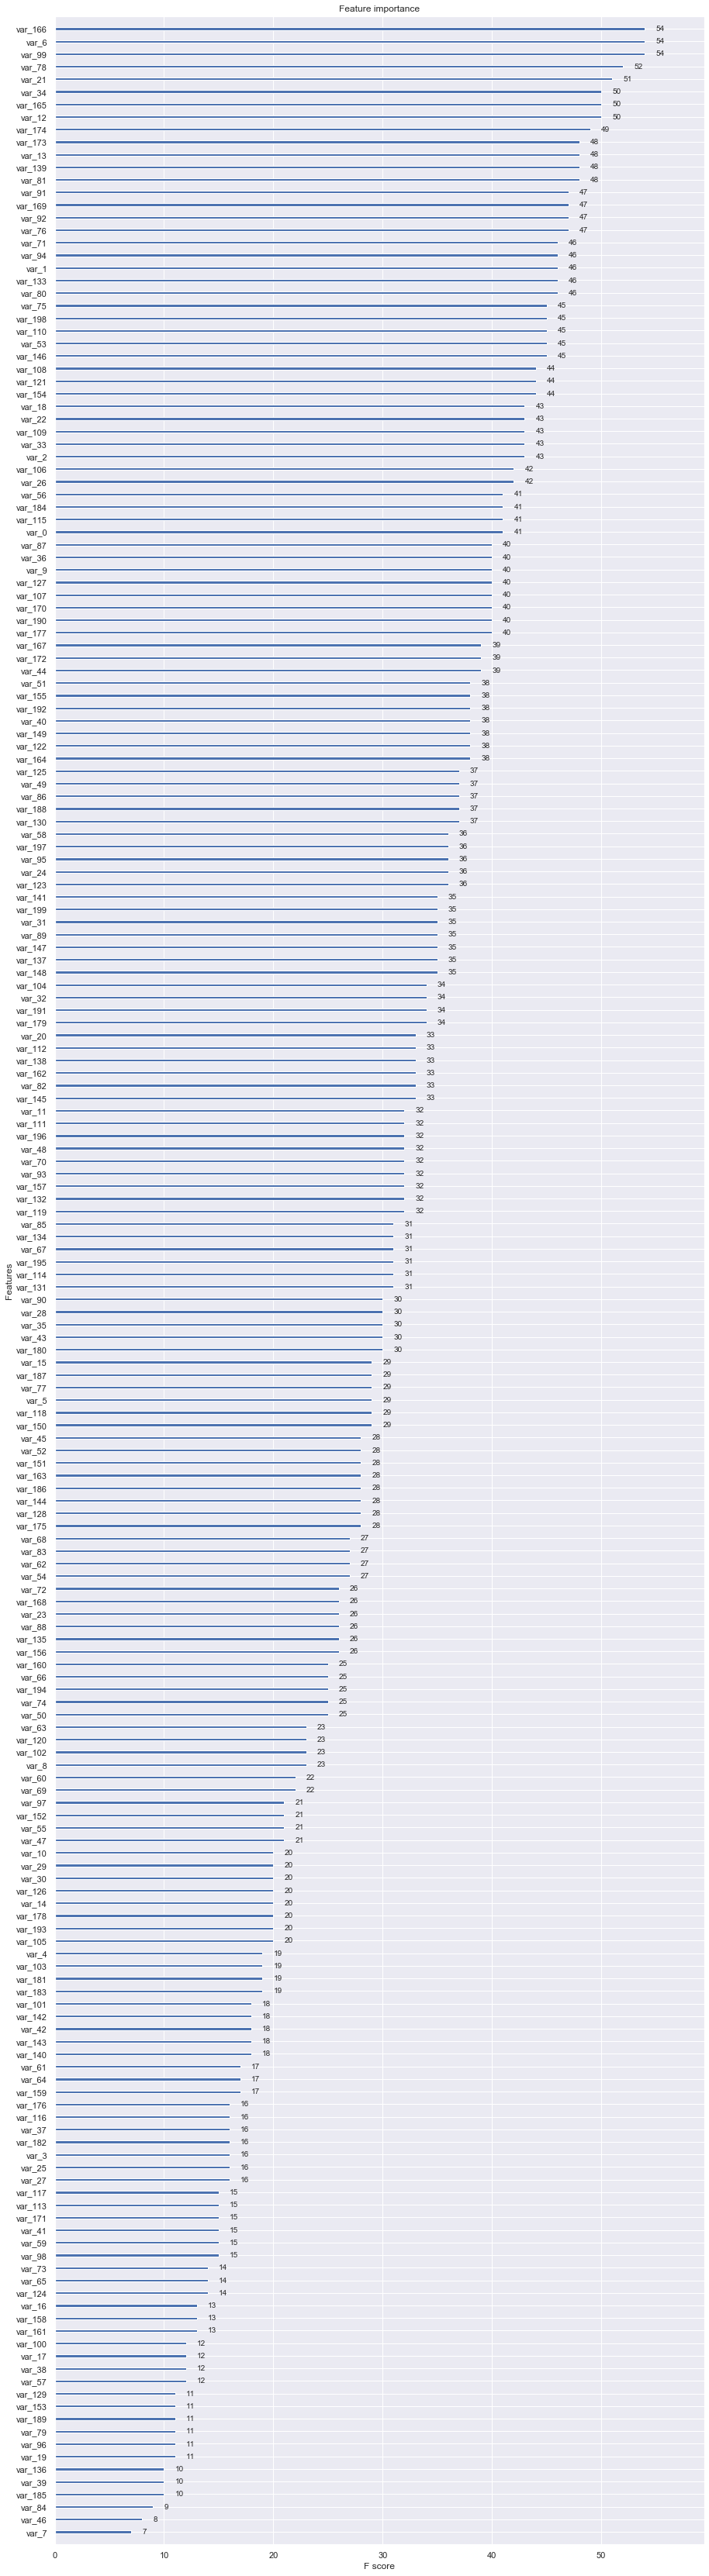

In [70]:
def my_plot_importance(booster, figsize, **kwargs): 
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)
my_plot_importance(xgbmodel, (15,60))

## Model ROC Curve

In [71]:
roc_values = []
for thresh in np.linspace(0, 1, 101):
    preds = get_preds(probas, thresh)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)

In [72]:
LR_roc_values = []
for thresh in np.linspace(0, 1, 101):
    preds = get_preds(proba_LR, thresh)
    tn, fp, fn, tp = confusion_matrix(y_test_LR, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    LR_roc_values.append([tpr, fpr])
LR_tpr_values, LR_fpr_values = zip(*LR_roc_values)

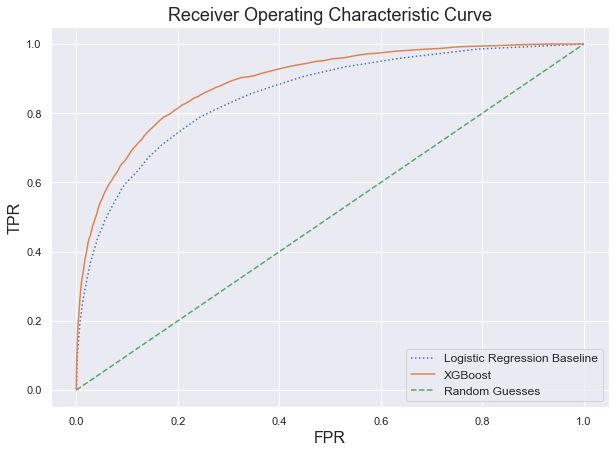

In [73]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(LR_fpr_values, LR_tpr_values,
        label='Logistic Regression Baseline',
        linestyle='dotted')
ax.plot(fpr_values, tpr_values,
        label='XGBoost')
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='Random Guesses',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

# Submission

In [74]:
def transform_data(data):
    X, _ = data_preprocess(data, 1., 'StandardScaler')
    dtest = xgb.DMatrix(X)
    return dtest

In [75]:
def make_csv(d_test, model):
    preds_final = model.predict(d_test)
    predictions = pd.Series(preds_final, index = test['ID_code'], name = 'target')
    return predictions.to_csv("submission.csv", header = True)

In [76]:
# load the model from disk
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [77]:
d_test = transform_data(test)
make_csv(d_test, loaded_model)
done()

### Submission Score: **0.89603**